# MODIS Water Random Forest GPU

Version: 0.2.0

Date modified: 03.01.2022

Modified by: Caleb Spradlin

In [2]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys
from pprint import pprint
import time

#GPU
import cudf
import cupy as cp
from cuml.ensemble import RandomForestClassifier as cumlRF
from cuml.model_selection import train_test_split
# Scikit learn
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
#from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

#sys.path.append('../')
#import notebook_util as nu

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
FIGURE_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
RASTER_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
MODEL_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/'

training_data_basepath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.1.0'

qaMaskPath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/qa'
waterMaskPath = '/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs'

test_data_basepath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/'

GPU = True
# TILE = 'Golden'
MODEL = 'rf'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = cp.float32

#############################
#VERSION 0.0.0 (2billion data points)
TILE = 'cleaned'#v2.0.1
DATA_VERSION='AGU'
offsets_indexes = []#'x_offset', 'y_offset', 'year', 'julian_day']
##############################



# Columns that are offset, years, julian days, etc (always need to be dropped).
# offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day', ]#'tileID']
# Columns that the user wants to drop for training purposes. 
colsToDrop = [] # ['sur_refl_b03_1','sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1','ndwi1','ndwi2']
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [4]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    df = pd.read_parquet(fpath).astype(dataType) if cpu else cudf.read_parquet(fpath).astype(dataType)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

## Data 
- Read in to cuDF Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

In [6]:
glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE))
data_paths = [fv for fv in glob.glob(glob_string)]
data_path = data_paths[0]
pprint(data_paths)
print(data_path)

['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.1.0/MOD09_Golden_Masked_5500000_4_1_0.parquet.gzip',
 '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.1.0/MOD09_Golden_Masked_865249_Water_Imbalance_4_2_0.parquet.gzip',
 '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.1.0/MOD09_Golden_Masked_957000_4_2_0.parquet.gzip']
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v4.1.0/MOD09_Golden_Masked_5500000_4_1_0.parquet.gzip


In [7]:
%%time
X_train, X_test, y_train, y_test = load_data(fpath=data_path,
         colsToDrop=colsToDropTraining,
         dataType=DATA_TYPE,
         cpu=False,
         splitXY=True,
         trainTestSplit=True)

kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

CPU times: user 2.87 s, sys: 1.78 s, total: 4.65 s
Wall time: 18.2 s


5

## Load in data for use of visualizations 
(skip this if you just want to train model)

In [8]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


In [9]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,4377036.0,841.756683,990.602800,-100.0,161.000000,644.000000,1073.000000,13141.0
sur_refl_b02_1,4377036.0,1652.297916,1325.067395,-100.0,168.000000,1875.000000,2569.000000,12205.0
sur_refl_b03_1,4377036.0,512.664264,695.261231,-100.0,178.000000,343.000000,571.000000,9119.0
sur_refl_b04_1,4377036.0,736.266580,799.828187,-100.0,273.000000,612.000000,878.000000,9550.0
sur_refl_b05_1,4377036.0,1889.608486,1472.393489,-100.0,145.000000,2261.000000,3108.000000,9383.0
sur_refl_b06_1,4377036.0,1638.144005,1387.756363,-100.0,159.000000,1590.000000,2660.000000,7855.0
sur_refl_b07_1,4377036.0,1081.293943,1091.638346,-100.0,71.000000,808.000000,1705.000000,9357.0
ndvi,4377036.0,257.861140,11995.335524,-1990000.0,-1959.948730,2474.226807,4989.705078,1770000.0
ndwi1,4377036.0,-2182.634433,11502.094829,-2010000.0,-2938.923523,-885.902588,749.475159,1990000.0
ndwi2,4377036.0,-314.014098,13456.534220,-2010000.0,-1313.798340,926.877014,4129.750977,1990000.0


In [10]:
def output_interesting_idx(df, column, threshold, greaterThan=True):
    dfToReturn = df[df[column] > threshold] if \
        greaterThan else df[df[column] < threshold]
    return dfToReturn

In [11]:
output_interesting_idx(X_train, 'ndvi', 10000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
2418340,13.0,-14.0,148.0,73.0,-1.0,55.0,18.0,270000.000000,-16829.267578,-80000.000000
577219,7.0,-8.0,96.0,76.0,-7.0,50.0,15.0,150000.000000,-13809.523438,-32857.144531
2575004,-1.0,18.0,-100.0,-59.0,17.0,16.0,18.0,11176.470703,588.235291,0.000000
1291970,2.0,-26.0,175.0,122.0,-28.0,353.0,291.0,11666.666992,-11590.213867,-11962.263672
2778189,3.0,-25.0,201.0,105.0,1.0,68.0,22.0,12727.272461,-21627.906250,156666.671875
...,...,...,...,...,...,...,...,...,...,...
278258,4.0,-11.0,171.0,116.0,-12.0,322.0,239.0,21428.572266,-10707.395508,-10964.912109
5372834,10.0,-21.0,189.0,133.0,-6.0,351.0,281.0,28181.818359,-11272.727539,-11615.384766
5009957,1.0,-3.0,108.0,65.0,-3.0,46.0,23.0,20000.000000,-11395.348633,-13000.000000
469140,-69.0,2661.0,183.0,481.0,2926.0,1522.0,536.0,10532.407227,2722.926025,6646.856445


## Random Forest Model

### Model Definition

In [12]:
hyperparameters = {
 'n_estimators': 400,
 'max_depth': 16,
 'max_features': 'auto',
 'n_bins': 128,
 'split_criterion': 0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_impurity_decrease': 0.0,
 'bootstrap': True,
 'max_samples': 1.0,
 'max_leaves': -1,
 'accuracy_metric': None,
 'max_batch_size': 4096,
 'n_streams': 4,
 'dtype': None,
 'min_weight_fraction_leaf': None,
 'n_jobs': None,
 'max_leaf_nodes': None,
 'min_impurity_split': None,
 'oob_score': None,
 'random_state': 42,
 'warm_start': None,
 'class_weight': None,
 'criterion': None}

In [13]:
classifier = cumlRF(**hyperparameters)

# Training

## K-Fold Cross Validation

In [16]:
%%time
scores = []
for trainIdx, testIdx in kf.split(X_train):
    print("Train {}, Test {}".format(trainIdx, testIdx))
    X_train_valid, X_test_valid = X_train.iloc[trainIdx], X_train.iloc[testIdx]
    y_train_valid, y_test_valid = y_train.iloc[trainIdx], y_train.iloc[testIdx]
    print(type(X_train_valid))
    print(type(y_test_valid))
    print('Fitting model')
    st = time.time()
    classifier.fit(X_train_valid, y_train_valid)
    et = time.time()
    print('Time to fit model: {}s'.format(et-st))
    print('Getting score')
    score = classifier.score(X_test_valid, y_test_valid)
    print('Predicting for test set')
    test_predictions = classifier.predict(X_test)
    print(classification_report(y_test.to_numpy(), test_predictions.to_numpy()))
    print('Score: {}'.format(score))
    scores.append(score)
    del test_predictions, score

Train [ 875408  875409  875410 ... 4377033 4377034 4377035], Test [     0      1      2 ... 875405 875406 875407]
<class 'cudf.core.dataframe.DataFrame'>
<class 'cudf.core.series.Series'>
Fitting model
Time to fit model: 70.04759049415588s
Getting score
Training accuracy score: 0.9791640043258667
Predicting for test set
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    583329
         1.0       0.98      0.97      0.98    510930

    accuracy                           0.98   1094259
   macro avg       0.98      0.98      0.98   1094259
weighted avg       0.98      0.98      0.98   1094259

Score: 0.9791640043258667
Train [      0       1       2 ... 4377033 4377034 4377035], Test [ 875408  875409  875410 ... 1750812 1750813 1750814]
<class 'cudf.core.dataframe.DataFrame'>
<class 'cudf.core.series.Series'>
Fitting model
Time to fit model: 66.22901439666748s
Getting score
Predicting for test set
              precision    recall  f1-sco

In [17]:
scoreAvg = np.asarray(scores).mean()
print('Average accuracy score: {}'.format(scoreAvg))

Average accuracy score: 0.979223370552063
Best accuracy score: 0.9795363545417786


## Regular fitting

In [18]:
classifier = cumlRF(**hyperparameters)

In [19]:
%%time

classifier.fit(X_train, y_train)

CPU times: user 1min 40s, sys: 1min 41s, total: 3min 21s
Wall time: 1min 16s


RandomForestClassifier()

### Get model metrics

In [20]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.979

In [21]:
score = round(score, 3)

In [22]:
train_predictions = classifier.predict(X_train)#.to_array()
test_predictions = classifier.predict(X_test)#.to_array()
prediction_probs = classifier.predict_proba(X_test)#.to_pandas()
#prediction_probs = prediction_probs[:][1]

In [23]:
test_predictions = test_predictions.astype(cp.int16)
y_test_int = y_test.astype(cp.int16)

In [25]:
print('Train Performance')
print('-------------------------------------------------------')
print(classification_report(y_train.to_numpy(), train_predictions.to_numpy()))
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test.to_numpy(), test_predictions.to_numpy()))
cm = confusion_matrix(y_test_int.to_numpy(), test_predictions.to_numpy())
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)
#auc_score = roc_auc_score(y_test_int, prediction_probs)
print('Roc_auc score')
print('-------------------------------------------------------')
#print(auc_score)

Train Performance
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98   2329630
         1.0       0.99      0.98      0.98   2047406

    accuracy                           0.98   4377036
   macro avg       0.98      0.98      0.98   4377036
weighted avg       0.98      0.98      0.98   4377036

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    583329
         1.0       0.98      0.97      0.98    510930

    accuracy                           0.98   1094259
   macro avg       0.98      0.98      0.98   1094259
weighted avg       0.98      0.98      0.98   1094259

Test Recall
-------------------------------------------------------
0.9846296001056007
Confusion Matrix
-------------------------------------------------------
[[574363   8966]
 [ 13774 497156]]
Roc_

In [26]:
%%time
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=5,
                                                        random_state=42)

CPU times: user 8min 42s, sys: 57.1 s, total: 9min 39s
Wall time: 32.6 s


Text(0.5, 0, 'Permutation Importance')

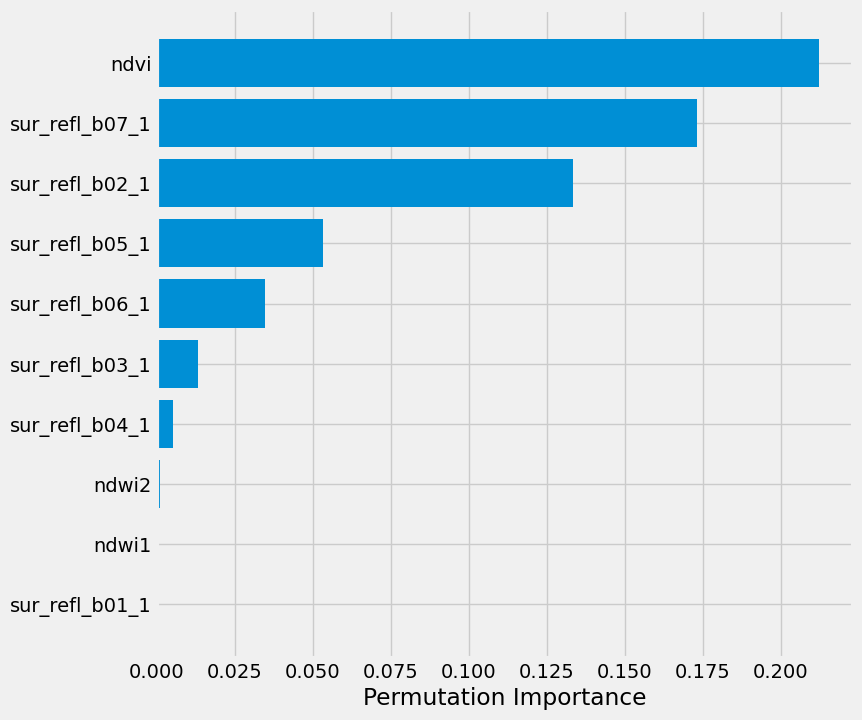

In [27]:
png_save_path = 'mw_{}_{}_{}_{}_{}_permutation_importance.png'.format(
    TILE,
    score,
    hyperparameters['n_estimators'],
    MODEL,
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

png_save_path = os.path.join(FIGURE_OUTPUT_DIR, png_save_path)

sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
# plt.savefig(png_save_path)

In [28]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, prediction_probs, y_test_int

## Save the model for future use

In [29]:
model_save_path = 'mw_{}_{}_{}_{}_{}_2.0.0_tuned_{}.sav'.format(TILE,
                                                              score,
                                                              hyperparameters['n_estimators'],
                                                              MODEL,
                                                              'gpu',
                                                              datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))
model_save_path = os.path.join(MODEL_OUTPUT_DIR, model_save_path)
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: /explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_Golden_0.979_400_rf_gpu_2.0.0_tuned_2023_02_16_16_57.sav
RandomForestClassifier()


['/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_Golden_0.979_400_rf_gpu_2.0.0_tuned_2023_02_16_16_57.sav']

# Testing: Raster testing

In [30]:
import sys
sys.path.append('../../..')
from modis_water_training.model.TabularModisDataGenerator import TabularModisDataGenerator

In [31]:
TILE = 'h11v10'
DAY = 201
YEAR = 2006

In [32]:
tabularGen = TabularModisDataGenerator(tile=TILE, year=YEAR, julianDays=[DAY])
sensorDir = f'/css/modis/Collection6.1/L2G/MOD09GA/{YEAR}'
modisFilesDict = tabularGen._readFiles(julianDay=DAY, sensorDir=sensorDir)
modisFilesList = list(modisFilesDict.values())
qa_mask, qa_mask_path = tabularGen._generateBadDataMask(day=DAY, files=modisFilesDict)

/css/modis/Collection6.1/L2G/MOD09GA/2006/*GA.A2006201.h11v10*.hdf
/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf
Julian day: 201
Files: {'SensorZenith_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:SensorZenith_1', 'SolarZenith_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:SolarZenith_1', 'state_1km_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_1km_2D:state_1km_1', 'sur_refl_b03_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b03_1', 'sur_refl_b04_1': 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1', 'sur_refl_b05_1':

In [33]:
vars_list_gq = [fn for fn in modisFilesList
            if 'sur_refl' in fn and 'GQ' in fn]
vars_list_gq.sort()

vars_list_ga = [fn for fn in modisFilesList
            if 'sur_refl' in fn and 'GQ' not in fn]
vars_list_ga.sort()

vars_list = vars_list_gq
vars_list.extend(vars_list_ga)

vars_list

['HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GQ/2006/MOD09GQ.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_2D:sur_refl_b01_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GQ/2006/MOD09GQ.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_2D:sur_refl_b02_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b03_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b05_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b06_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_r

### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [34]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(xRes=231.656358, yRes=231.656358, separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

In [35]:
%%time
im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[ 282 2985  173 ... 8273 2822 6797]
 [ 289 3045  173 ... 8266 2913 6851]
 [ 275 3198  180 ... 8416 3050 6898]
 ...
 [ 317 1559  144 ... 6620  562 4395]
 [ 252 1447  126 ... 7033  770 4863]
 [ 252 1447  126 ... 7033  770 4863]]
460.8 MB size
CPU times: user 6.8 s, sys: 963 ms, total: 7.77 s
Wall time: 15.5 s


### Load in the model

In [36]:
def predictRaster(img_chunk, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    print('Converting host array to GPU-based dataframe')
    df = cudf.DataFrame(cp.asarray(img_chunk), columns=v_names, dtype=cp.float32)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    print('Making predictions from raster')
    predictions = classifier.predict(df)
    predictionsProbs = classifier.predict_proba(df)
    print('Converting GPU-bound predictions to host')
    predictionsPandas = predictions.to_pandas().astype(np.int16)
    predictionsProbaPandas = predictionsProbs.to_pandas().astype(np.float32)
    predictions = None
    predictionsProbs = None
    return predictionsPandas, predictionsProbaPandas, df.to_pandas()

In [37]:
%%time
predictedRaster, predictedProbaRaster, df = predictRaster(im)

Converting host array to GPU-based dataframe
Making predictions from raster
Converting GPU-bound predictions to host
CPU times: user 25.4 s, sys: 13 s, total: 38.5 s
Wall time: 17.7 s


### Description of the predicted probability for each pixel in the raster (no bad-data vals masked yet)

#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [38]:
shp = (4800, 4800)
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

(4800, 4800)

### Import the QA Mask and the Water Mask for the h09v05 tile

In [39]:
water_list = [fn for fn in glob.glob(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*{}_v5.tif'.format(TILE, YEAR)))]
print(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*.tif'.format(TILE)))
water_mask_path = water_list[0]
print(water_mask_path)
water_mask = gdal.Open(water_mask_path, gdal.GA_ReadOnly)
waterMaskMatrix = water_mask.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMask = None

/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/*h11v10*.tif
/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/MOD44W_h11v10_2006_v5.tif


In [40]:
waterMaskMatrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int16)

### Mask out results if QA Mask says pixel is "bad"
Mask out water mask if QA Mask says pixel is "bad"

In [45]:
maskedResult = np.where(qa_mask == 0, reshp, 255)
waterMasked = np.where(qa_mask == 0, waterMaskMatrix, 255)
waterMaskRavel = waterMasked.ravel()
imWater = (waterMaskRavel == 1)

## Output predicted raster to GeoTiff

In [46]:
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))
print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/2006_201_h11v10_predicted_rf.tif
/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/waterMask_2006_qa_201.tif
/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/2006_201_h11v10_predicted_probabilities_rf.tif
Transform
(-7783653.637667, 231.65635826395845, 0.0, -1111950.519667, 0.0, -231.65635826374995)
Projection
PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Width
4800
Height
4800


In [47]:
import folium
import glob
import numpy as np
import os
import rasterio as rio
import tempfile

from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer 

In [48]:
# -----------------------------------------------------------------------------
# Uses rasterio to open a raster, get the metadata and crs
# associated with it and get all the subdatasets in the file.
# This is very useful for hdf files such as MODIS hdfs.
# -----------------------------------------------------------------------------
def print_subdatasets(filename):
    bands_to_return = []
    with rio.open(filename) as dataset:
        meta_data = dataset.meta
        crs = dataset.read_crs()
        
        print([name for name in dataset.subdatasets if search_term in name])

# -----------------------------------------------------------------------------
# Gets a tiff that has the correct metadata for that tile, gets the metadata
# from the source tif and copies to a destination tiff. 
# -----------------------------------------------------------------------------     
def add_metadata_to_annual_product(filepath, model_type, year, tile):
    metadata_pull_src = [fv for fv in glob.glob(os.path.join(filepath, "{}-1*-{}-MOD-*.tif".format(year, tile)))][0]
    with rio.open(metadata_pull_src) as src:
        src_meta = src.meta
    dst_tiffs = [os.path.join(filepath, fn) for fn in os.listdir(filepath) if "{0}-{1}".format(year, tile) in os.path.basename(fn)]
    [copy_meta(dst_tiff, src_meta, metadata_pull_src) for dst_tiff in dst_tiffs]

# -----------------------------------------------------------------------------
# Given a path to a tiff with no metadata, assign the metadata given to that
# tiff.
# -----------------------------------------------------------------------------     
def copy_meta(dst_path, src_meta, src_name):
    print('Copying metadata from {} to {}'.format(src_name, dst_path))
    with rio.open(dst_path, 'r+') as dst:
        dst.crs = src_meta['crs']
        dst.transform = src_meta['transform']        

# -----------------------------------------------------------------------------
# Given a tiff file as input, open the tiff and get the transform needed to
# reproject from the tiff's source crs to the one we want (EPSG:3857).
# For each band in the tiff, open then reproject it into the desired crs
# then write to a temporary file. Return the path to the temp file.
# -----------------------------------------------------------------------------
def reproject_to_3857(input_tiff):
    # Set desitnation CRS
    dst_crs = f"EPSG:3857"

    # set out path
    out_path_rproj = os.path.join(tempfile.gettempdir(), input_tiff.split('/')[-1].replace('.tif','-3857.tif'))

    with rio.open(input_tiff) as src:
        # get src bounds and transform
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        print('Transform: {}'.format(transform))
        print('Width: {} Height: {}'.format(width, height))
        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs,
                   'transform': transform,
                   'width': width,
                   'height': height})
    
        # reproject and write to file
        with rio.open(out_path_rproj, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(source=rio.band(src, i),
                      destination=rio.band(dst, i),
                      src_transform=src.transform,
                      src_crs=src.crs,
                      dst_transform=transform,
                      dst_crs=dst_crs,
                      resampling=Resampling.nearest)
    return out_path_rproj

# -----------------------------------------------------------------------------
# In order for folium to work properly we need to pass it the bounding box
# of the tiff in the form of lat and lon. This is done by using rasterio.
# -----------------------------------------------------------------------------
def get_bounds(tiff_3857):
    with rio.open(tiff_3857) as src:
        src_crs = src.crs['init'].upper()
        min_lon, min_lat, max_lon, max_lat = src.bounds
    bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]]
    bounds = []
    dst_crs = 'EPSG:4326'
    for item in bounds_orig:   
        #converting to lat/lon
        lat = item[0]
        lon = item[1]
        proj = Transformer.from_crs(int(src_crs.split(":")[1]), int(dst_crs.split(":")[1]), always_xy=True)
        lon_n, lat_n = proj.transform(lon, lat)
        bounds.append([lat_n, lon_n])
    center_lon = bounds[0][1] + (bounds[1][1] - bounds[0][1])/2
    center_lat = bounds[0][0] + (bounds[1][0] - bounds[0][0])/2
    return {'bounds': bounds, 'center': (center_lon, center_lat)}

# -----------------------------------------------------------------------------
# Use rasterio to open and read in the desired band name as a nd-array.
# -----------------------------------------------------------------------------
def open_and_get_band(file_name, band_num=1):
    with rio.open(file_name) as data:
        b = data.read(band_num)
    return b

# -----------------------------------------------------------------------------
# Given an nd-array (band) and the bounds in lat lon of the nd-array, return
# a folium layer. To add on the map.
# -----------------------------------------------------------------------------
def get_overlay(band, meta_dict, name, opacity=1.0, show=True):
    return folium.raster_layers.ImageOverlay(band, 
                                             bounds=meta_dict['bounds'], 
                                             name=name, 
                                             opacity=opacity, 
                                             show=show)

# -----------------------------------------------------------------------------
# We don't need to keep those temp files we made for the reprojections around.
# -----------------------------------------------------------------------------
def cleanup(filename):
    if os.path.exists(filename):
        os.remove(filename)
    else:
        print('No file: {} exists.'.format(filename))

In [49]:
mask_3857 = reproject_to_3857(outPath)
mod44_3857 = reproject_to_3857(water_mask_path)
qa_3857 = reproject_to_3857(qa_mask_path)

mask_d = get_bounds(mask_3857)
mod44_d = get_bounds(mod44_3857)
qa_d = get_bounds(qa_3857)

mask_b1 = open_and_get_band(mask_3857, 1)
mask_b1 = np.where(mask_b1 == 255, 0, mask_b1)
mod44_b1 = open_and_get_band(mod44_3857, 1)
mod44_b1 = np.where(mod44_b1 == 255, 0, mod44_b1)
qa_b1 = open_and_get_band(qa_3857, 1)

cleanup(mask_3857)
cleanup(mod44_3857)
cleanup(qa_3857)

zeros = np.zeros_like(mask_b1)
mask_rgba = np.dstack((mask_b1, zeros, zeros, mask_b1))
mod44_rgba = np.dstack((zeros, mod44_b1, zeros, mod44_b1))
qa_rgba = np.dstack((qa_b1, qa_b1, qa_b1, qa_b1))

Transform: | 207.27, 0.00,-8292460.94|
| 0.00,-207.27,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 207.27, 0.00,-8292471.14|
| 0.00,-207.27,-1118891.21|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 207.27, 0.00,-8292460.94|
| 0.00,-207.27,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568


In [50]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google', control_scale=True)

In [51]:
from folium import plugins


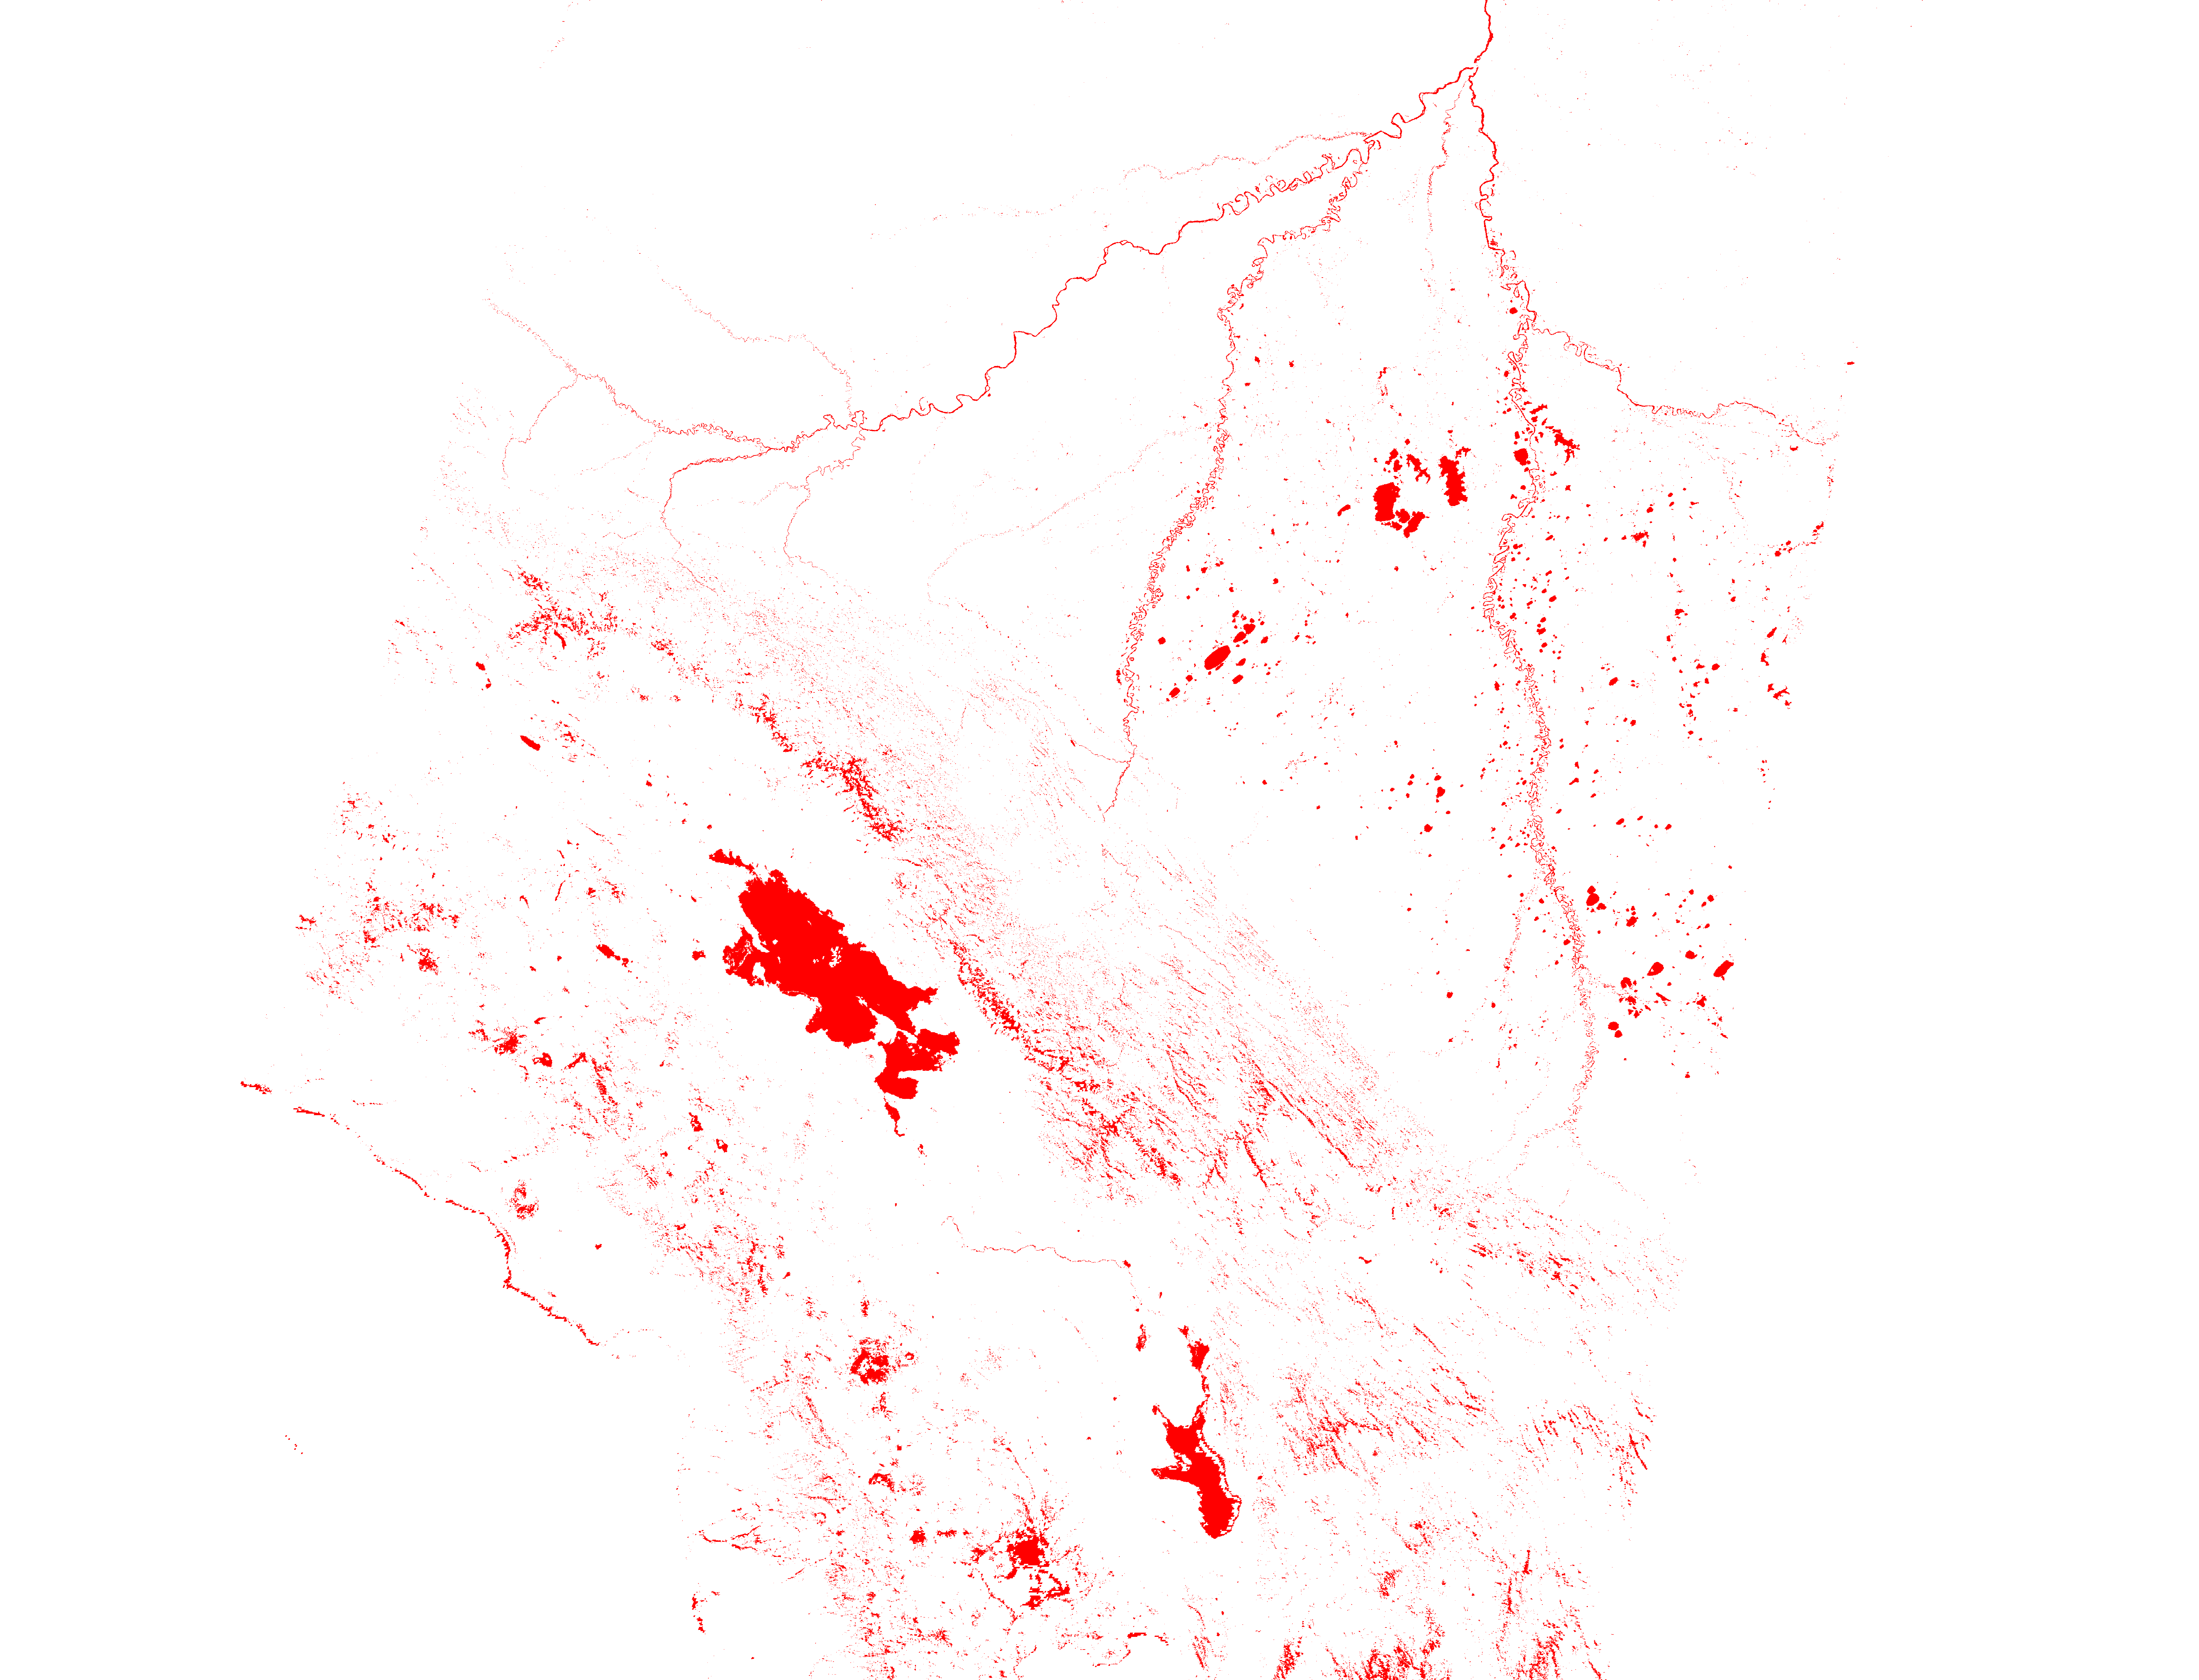
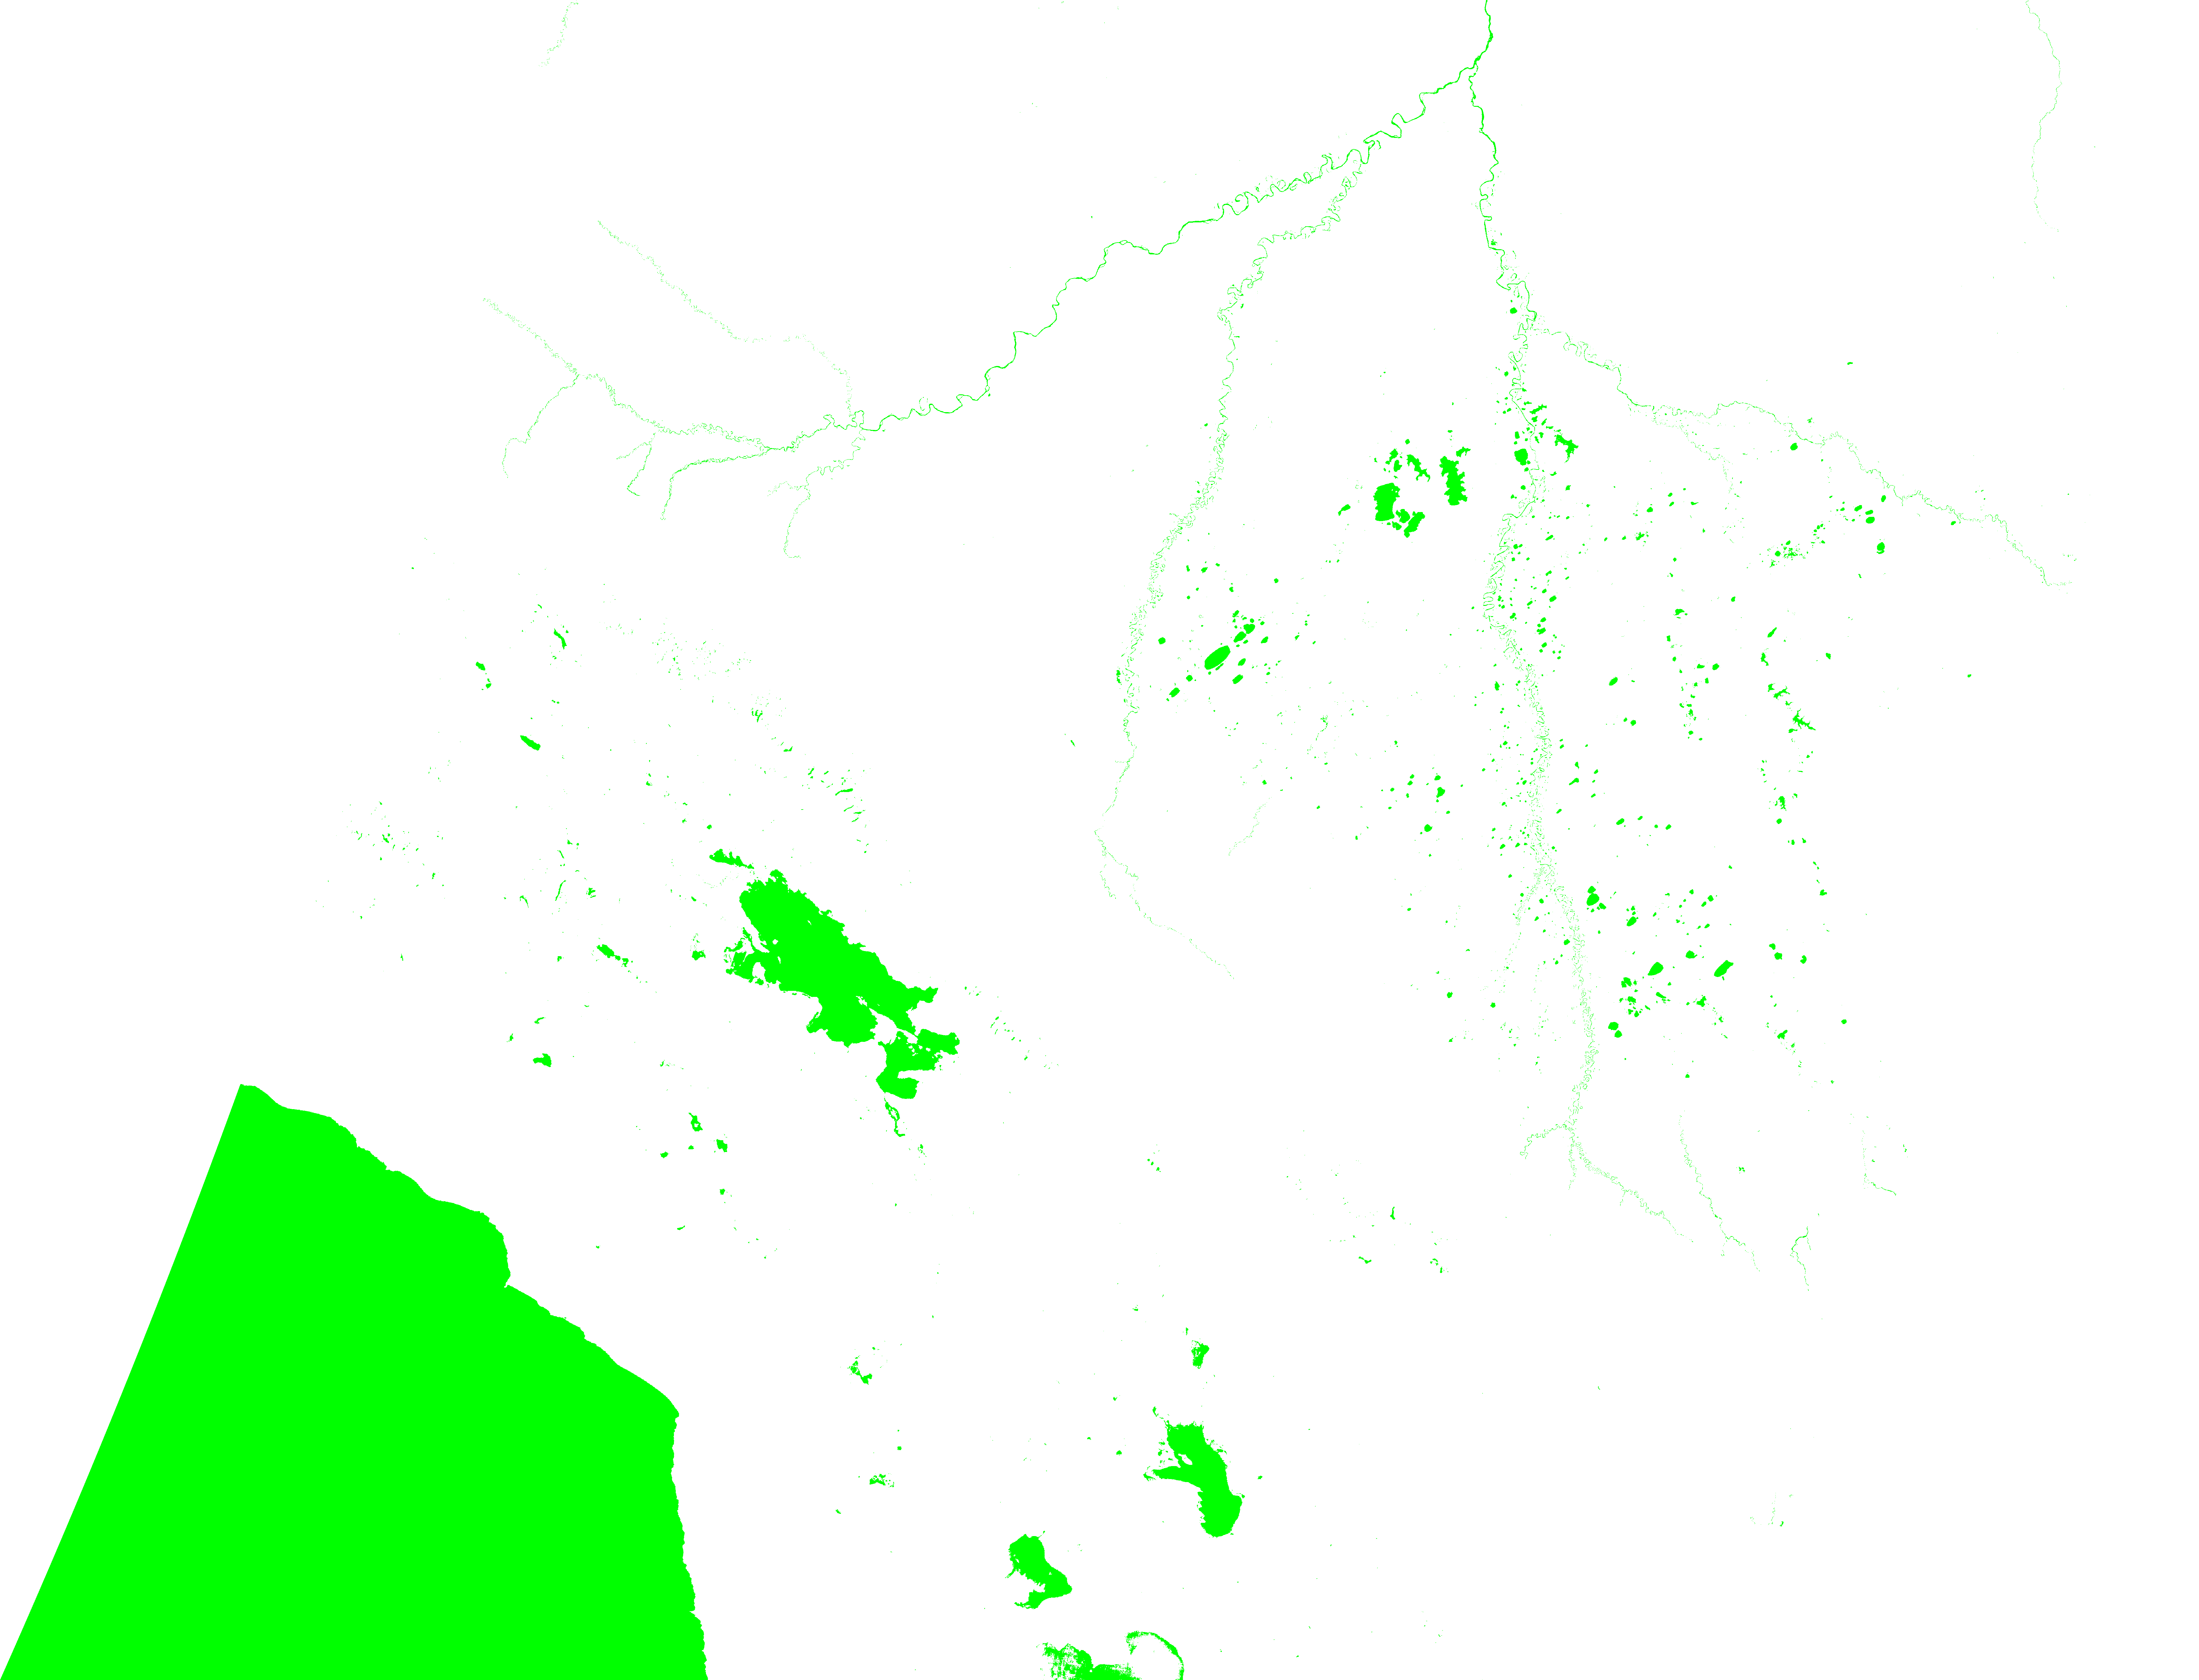
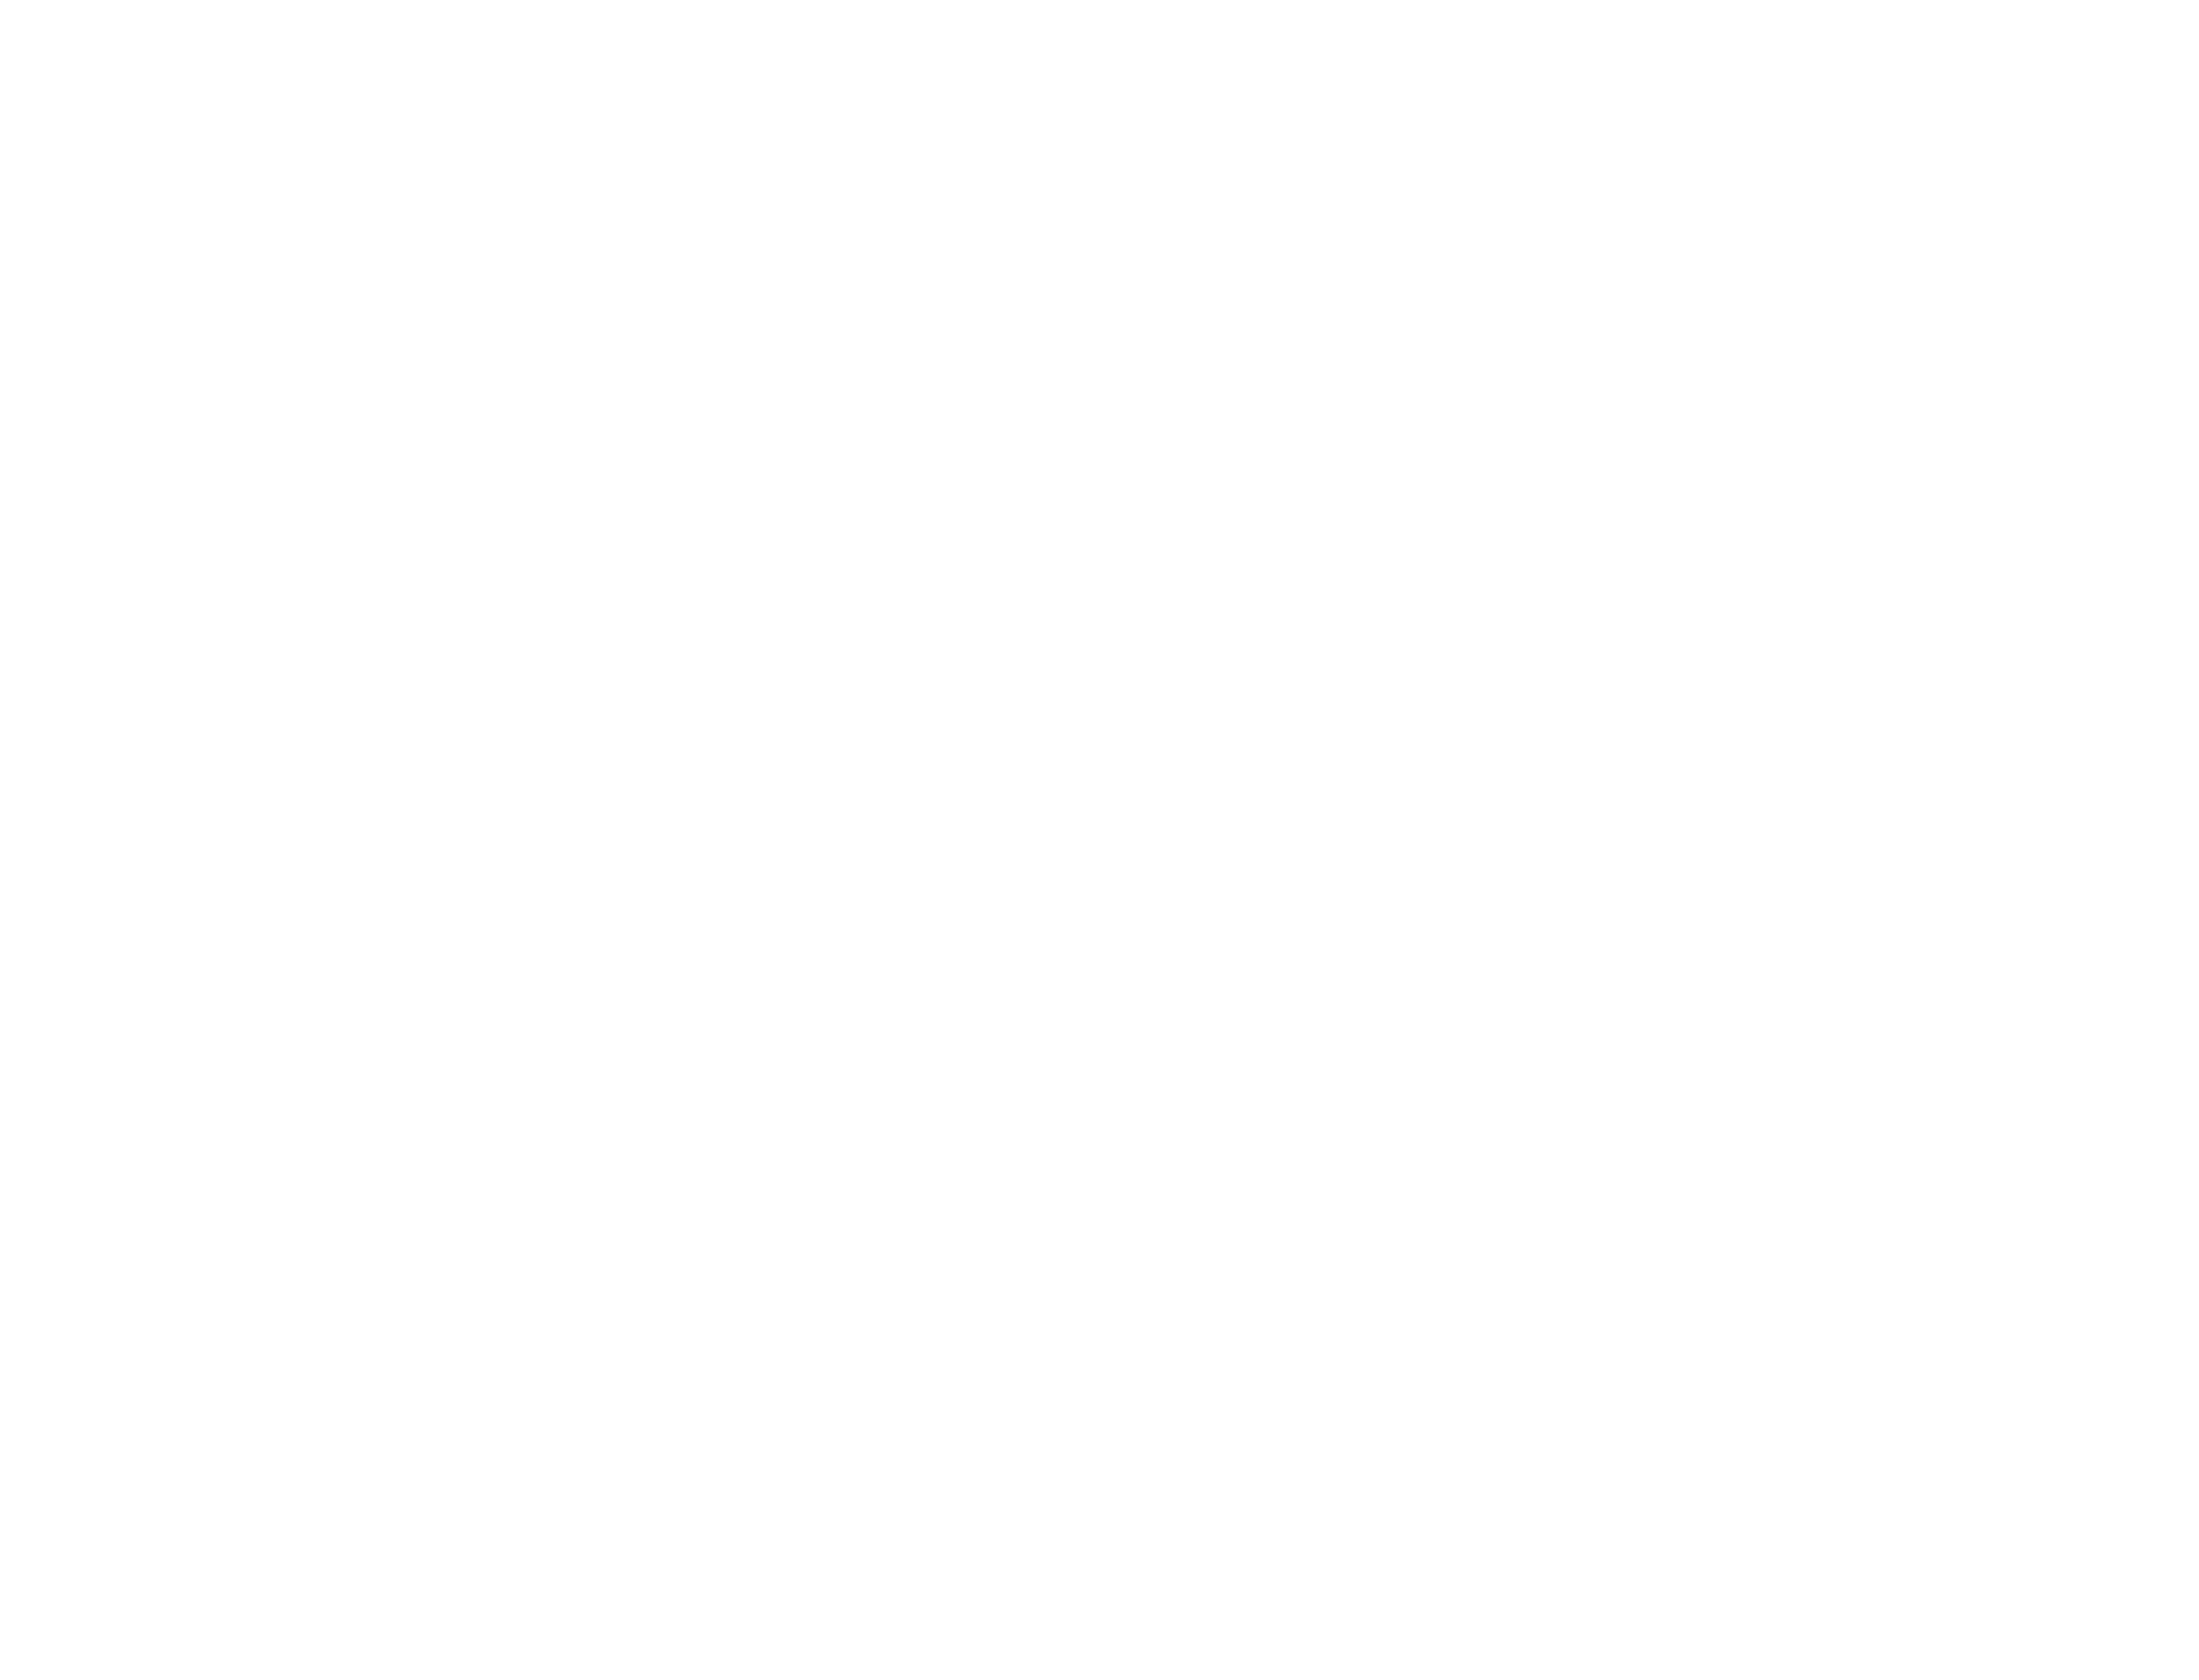

In [52]:
m.add_child(get_overlay(mask_rgba, mask_d, '{}-{}-{} model water mask'.format(YEAR, DAY, TILE), opacity=0.8))
m.add_child(get_overlay(mod44_rgba, mod44_d, '{} {} MOD44W mask'.format(TILE, YEAR), opacity=0.8, show=False))
m.add_child(get_overlay(qa_rgba, qa_d, '{}-{}-{} MW QA mask'.format(YEAR, DAY, TILE), opacity=0.8, show=False))
m.add_child(plugins.MousePosition())
m.add_child(plugins.MeasureControl())
m.add_child(folium.LayerControl())